In [13]:
import numpy as np
import skimage.io as io
import skimage.color as color
from skimage import transform
import os, sys

#print numpy array without scientific notation
np.set_printoptions(suppress=True)

In [14]:
def rgb_to_hsv(img_rgb):
    #normalize if rgb still in [0,255]
    if img_rgb.dtype == np.uint8 or img_rgb.dtype == np.uint16:
        img_rgb = np.array(img_rgb, dtype=float) / 255.
    
    #init img_hsv matrix
    img_hsv = np.empty_like(img_rgb)

    #calculate the Value matrix
    #V = img_rgb.max(-1) #alternative way
    V = np.max(img_rgb, axis =2)
    
    #calculate the Chroma matrix, also called delta in some resource
    #delta = img_rgb.ptp(-1) #alternative way
    C = V - np.min(img_rgb, axis=2)

    #calculate the Saturation matrix
    #noticed that: S = C/V. If V=0, then S=0
    #S = np.divide(C,V, out=np.zeros_like(C), where=V!=0)
    Ignore_divided_0 = np.seterr(invalid='ignore')
    S = C / V
    S[C == 0.] = 0.

    # Calculate the Hue Matrix
    # we will store the H' in img_hsv[idx, 0] temporarily
    # red is max
    idx = (img_rgb[..., 0] == V)
    img_hsv[idx, 0] = ((img_rgb[idx, 1] - img_rgb[idx, 2]) / C[idx]) % 6
    
    # green is max
    idx = (img_rgb[..., 1] == V)
    img_hsv[idx, 0] = 2. + (img_rgb[idx, 2] - img_rgb[idx, 0]) / C[idx]
    
    # blue is max
    idx = (img_rgb[..., 2] == V)
    img_hsv[idx, 0] = 4. + (img_rgb[idx, 0] - img_rgb[idx, 1]) / C[idx]
    
    #H = (img_hsv[..., 0] / 6.) % 1. #this is if we want to normalize H to be in [0,1]
    H = img_hsv[..., 0]*60. #this is for H in [0,360] degree
    # if C = 0
    H[C == 0.] = 0.
    
    np.seterr(**Ignore_divided_0)

    #combine all HSV components
    img_hsv[..., 0] = H
    img_hsv[..., 1] = S
    img_hsv[..., 2] = V

    # set all nan to 0
    img_hsv[np.isnan(img_hsv)] = 0
    
    return img_hsv

In [8]:
def hsv_to_rgb(img_hsv):
    #init img_rgb matrix
    img_rgb = np.empty_like(img_hsv)

    # generate 3 separated matrix for H, S, V
    H = img_hsv[..., 0]
    S = img_hsv[..., 1]
    V = img_hsv[..., 2]

    # Calcualte Chroma matrix
    C = V*S

    # H' matrix
    H_prime = H/60

    # X matrix
    X = C * (1- abs(H_prime%2 - 1))

    # convert H' to the condition, that is used to calculate R', G', B' later
    H_prime = H_prime.astype(int) % 6

    # m matrix
    m = V - C

    #calculate R',G',B' according to the condition of H', then add m[idx] to get RGB (see class notes)
    idx = H_prime[...] == 0
    img_rgb[idx, 0] = C[idx] + m[idx]
    img_rgb[idx, 1] = X[idx] + m[idx]
    img_rgb[idx, 2] = m[idx]

    idx = H_prime[...] == 1
    img_rgb[idx, 0] = X[idx] + m[idx]
    img_rgb[idx, 1] = C[idx] + m[idx]
    img_rgb[idx, 2] = m[idx]

    idx = H_prime[...] == 2
    img_rgb[idx, 0] = m[idx]
    img_rgb[idx, 1] = C[idx] + m[idx]
    img_rgb[idx, 2] = X[idx] + m[idx]

    idx = H_prime[...] == 3
    img_rgb[idx, 0] = m[idx]
    img_rgb[idx, 1] = X[idx] + m[idx]
    img_rgb[idx, 2] = C[idx] + m[idx]

    idx = H_prime[...] == 4
    img_rgb[idx, 0] = X[idx] + m[idx]
    img_rgb[idx, 1] = m[idx]
    img_rgb[idx, 2] = C[idx] + m[idx]

    idx = H_prime[...] == 5
    img_rgb[idx, 0] = C[idx] + m[idx]
    img_rgb[idx, 1] = m[idx]
    img_rgb[idx, 2] = X[idx] + m[idx]
    
    return img_rgb

In [15]:
def modify_img(img, h, s, v):
    img_hsv = rgb_to_hsv(img)
    img_hsv[..., 0] = (img_hsv[..., 0] + h) % 360
    img_hsv[..., 1] = (img_hsv[..., 1] + s) % 1
    img_hsv[..., 2] = (img_hsv[..., 2] + v) % 1

    img_rgb = hsv_to_rgb(img_hsv)
    return img_rgb

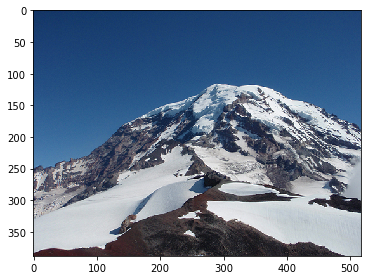

In [16]:
img = io.imread("Rainier1.png")
#Convert to RGB from RGBA (if applicable)
if img.ndim == 3 and img.shape[2] == 4:
    img = color.rgba2rgb(img)
io.imshow(img)


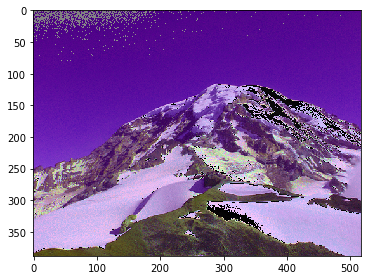

In [17]:
img = modify_img(img, 60, 0.2, 0.1)
io.imshow(img)
